In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DW_NAS_SMS_TRANSACTION_FCT'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_NAS_SMS_TRANSACTION_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_NAS_SMS_TRANSACTION_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 30823


In [20]:
df

,TXN_ID,COMPANY_KEY,SUB_BRANCH_KEY,SUB_BRANCH_CDE,CUSTOMER_KEY,CUSTOMER_CDE,SUB_SECTOR_CDE,SHORT_NAME,CUSTOMER_GROUP,SMS_PHONE,...,FROM_1,TRACENO,CONTENT_1,SEND_DT,CREATE_DT,PROCESS_DT,REC_CREATE_DT,REC_UPDATE_DT,NUM_OF_SEND_SMS,AMT
0,819930056,1,70,VN0012545,27339432,10428266,1700,DINH THI THU HUONG,110,84934268606,...,EBANKING,3cdab750-2a0e-11ed-83bd-c0a8ab0c0000,Sacombank 01/09/2022 22:53\nTK: 030037896965\n...,2022-09-01,2022-09-01 22:53:36,2022-09-01,2022-09-02 09:26:44,2022-09-02 09:26:44,1,NaN
1,819840182,1,70,VN0012545,27339432,10428266,1700,DINH THI THU HUONG,110,84934268606,...,EBANKING,e4e0e3be-2a01-11ed-83bd-c0a8ab0c0000,Sacombank 01/09/2022 21:25\nTK: 030037896965\n...,2022-09-01,2022-09-01 21:25:14,2022-09-01,2022-09-02 09:26:44,2022-09-02 09:26:44,1,NaN
2,819758497,1,345,VN0011342,41306373,9524974,1700,VND TGTT BAO HIEU,CN034,84916756272,...,EBANKING,2d0c3118-29fb-11ed-83bd-c0a8ab0c0000,Sacombank 01/09/2022 20:37\nTK: 050067023487\n...,2022-09-01,2022-09-01 20:37:09,2022-09-01,2022-09-02 09:26:44,2022-09-02 09:26:44,1,NaN
3,819755505,1,345,VN0011342,41306373,9524974,1700,VND TGTT BAO HIEU,CN034,84916756272,...,EBANKING,10d205d6-29fb-11ed-83bd-c0a8ab0c0000,Sacombank 01/09/2022 20:36\nTK: 050067023487\n...,2022-09-01,2022-09-01 20:36:21,2022-09-01,2022-09-02 09:26:44,2022-09-02 09:26:44,1,NaN
4,819126183,1,110,VN0011492,43413394,16503738,1700,VNDTGTT LE VAN PHU,103,84329153534,...,EBANKING,8f6f1824-29cf-11ed-9ba7-c0a8ab0c0000,Sacombank 01/09/2022 15:24\nTK: 070128227278\n...,2022-09-01,2022-09-01 15:24:56,2022-09-01,2022-09-02 09:26:44,2022-09-02 09:26:44,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30818,384538072,1,491,VN0014351,37953082,15905659,1700,TKPD NGUYEN NHAT ANH TRAM,103,84905515698,...,EBANKING,1108f7f0-830a-11ec-960e-c0a8ab0d0000,Sacombank 01/02/2022 09:52\nTK Phu Dong: 04010...,2022-02-01,2022-02-01 09:53:00,2022-02-01,2022-02-02 07:13:10,2022-02-02 07:13:10,1,NaN
30819,555819788,1,140,VN0012546,38952139,15963992,1700,NGO VAN KHANH,CN031,84855028529,...,EBANKING,3e71040a-c81d-11ec-b5d6-c0a8ab0c0000,Sacombank 30/04/2022 07:34\nTK: 030077930368\n...,2022-04-30,2022-04-30 07:34:07,2022-04-30,2022-05-01 11:28:43,2022-05-01 11:28:43,1,NaN
30820,556955982,1,140,VN0012546,38952139,15963992,1700,NGO VAN KHANH,CN031,84855028529,...,EBANKING,4ec301f2-c87a-11ec-a28c-c0a8ab0d0000,Sacombank 30/04/2022 18:40\nTK: 030077930368\n...,2022-04-30,2022-04-30 18:40:17,2022-04-30,2022-05-01 11:28:43,2022-05-01 11:28:43,1,NaN
30821,556902456,1,140,VN0012546,38952139,15963992,1700,NGO VAN KHANH,CN031,84855028529,...,EBANKING,b73e4566-c875-11ec-b5d6-c0a8ab0c0000,Sacombank 30/04/2022 18:07\nTK: 030077930368\n...,2022-04-30,2022-04-30 18:07:29,2022-04-30,2022-05-01 11:28:43,2022-05-01 11:28:43,1,NaN


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,TXN_ID,0.000000,int64,29469,0.956072,"[819930056, 819840182, 819758497]"
1,COMPANY_KEY,0.000000,int64,1,0.000032,[1]
2,SUB_BRANCH_KEY,0.000000,int64,484,0.015703,"[70, 345, 110]"
3,SUB_BRANCH_CDE,0.000000,object,484,0.015703,"[VN0012545, VN0011342, VN0011492]"
4,CUSTOMER_KEY,0.000000,int64,2003,0.064984,"[27339432, 41306373, 43413394]"
5,CUSTOMER_CDE,0.000000,object,1798,0.058333,"[10428266, 9524974, 16503738]"
6,SUB_SECTOR_CDE,0.000000,object,8,0.000260,"[1700, 1309, 1209]"
7,SHORT_NAME,0.000000,object,2071,0.067190,"[DINH THI THU HUONG, VND TGTT BAO HIEU, VNDTGT..."
8,CUSTOMER_GROUP,0.000000,object,34,0.001103,"[110, CN034, 103]"
9,SMS_PHONE,0.000000,object,1899,0.061610,"[84934268606, 84916756272, 84329153534]"


In [22]:
df.describe()

,TXN_ID,COMPANY_KEY,SUB_BRANCH_KEY,CUSTOMER_KEY,STATUS,NUM_OF_SEND_SMS,AMT
count,3.082300e+04,30823.0,30823.000000,3.082300e+04,30823.000000,30823.000000,6.513000e+03
mean,7.226091e+08,1.0,289.384713,3.696834e+07,0.996431,1.002174,-1.336104e+06
std,2.207047e+08,0.0,167.642674,6.507882e+06,0.059633,0.049281,6.686989e+07
min,3.171915e+08,1.0,1.000000,2.913501e+06,0.000000,1.000000,-2.930000e+09
25%,4.935745e+08,1.0,161.000000,3.352570e+07,1.000000,1.000000,0.000000e+00
50%,7.515844e+08,1.0,267.000000,3.695936e+07,1.000000,1.000000,0.000000e+00
75%,9.325742e+08,1.0,385.000000,4.235227e+07,1.000000,1.000000,2.142360e+05
max,1.040956e+09,1.0,715.000000,4.693704e+07,1.000000,3.000000,1.285000e+09


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', ''
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
7,SHORT_NAME,0.000000,object,2071,0.067190,"[DINH THI THU HUONG, VND TGTT BAO HIEU, VNDTGT..."
8,CUSTOMER_GROUP,0.000000,object,34,0.001103,"[110, CN034, 103]"
11,PROVIDER,0.000000,object,4,0.000130,"[VNPAY, IRIS-OTP, IRIS]"
12,TELCO,0.000000,object,6,0.000195,"[MBF, VNP, VTL]"
13,TELCOMNP,0.000000,object,6,0.000195,"[MBF, VNP, VTL]"
14,STATUS,0.000000,int64,2,0.000065,"[1, 0]"
15,SERVICE,0.000000,object,18,0.000584,"[BIENDONGSODU, OTP, SmsCredit]"
16,APPNAME,0.318593,object,8,0.000260,"[IIB, None, MNS]"
17,FROM_1,0.000000,object,4,0.000130,"[EBANKING, OTP-NHDT, OTP-TTT]"
20,SEND_DT,0.000000,datetime64[ns],31,0.001006,"[2022-09-01T00:00:00.000000000, 2022-09-02T00:..."


TGTT VND CTY CPCN TRUONG MINH THINH    2169
TK THE PLUS MAI THI GON                 479
VND TKTT VU BA SON                      430
NGUYEN TRAN VIET DE                     306
NGUYEN THI MY LAN                       244
                                       ... 
TKTT VND LE THI NGAN                      1
DO THI LEM                                1
VND TGTT HA THANH                         1
TKTT VND NGUYEN VU HANH PHUOC             1
TKTT VND LE BE BA                         1
Name: SHORT_NAME, Length: 2071, dtype: int64

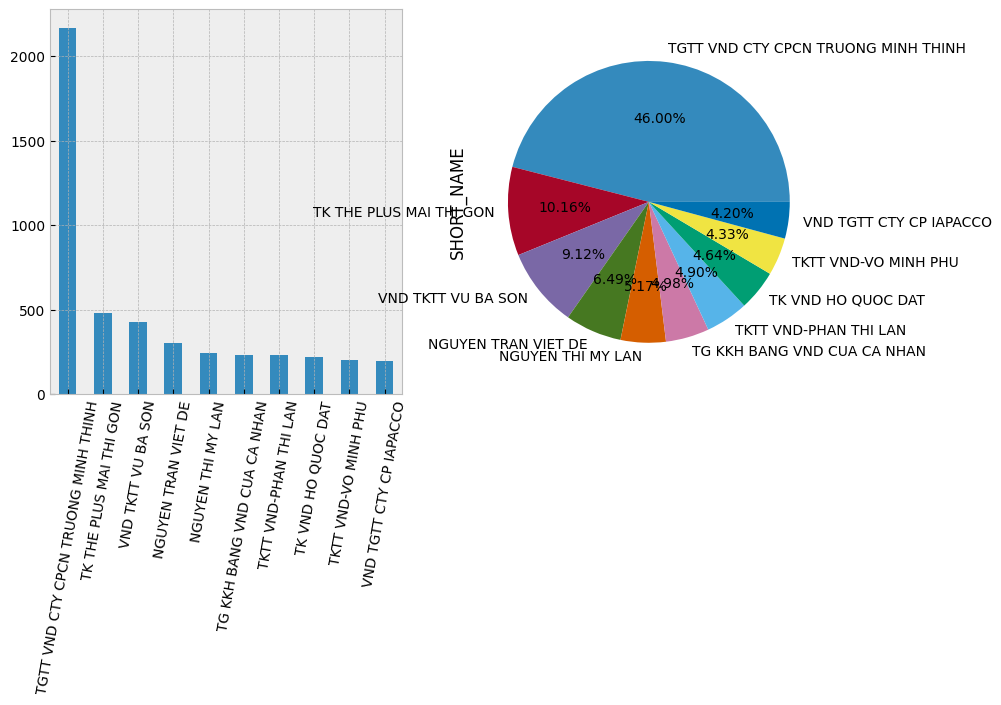

-1       7650
CN035    4310
110      4024
CN034    3325
103      2700
DN024    2435
104      1644
CN036    1433
CN045     732
CN017     463
CN016     416
DN026     270
108       248
CN050     230
CN051     225
CN040     129
DN029     112
DN027      96
DN021      73
200        69
DN032      59
CN031      53
101        36
DN059      33
DN040      16
CN022      11
DN081       7
DN025       6
DN058       5
DN060       5
CN033       3
202         3
CN032       1
DN033       1
Name: CUSTOMER_GROUP, dtype: int64

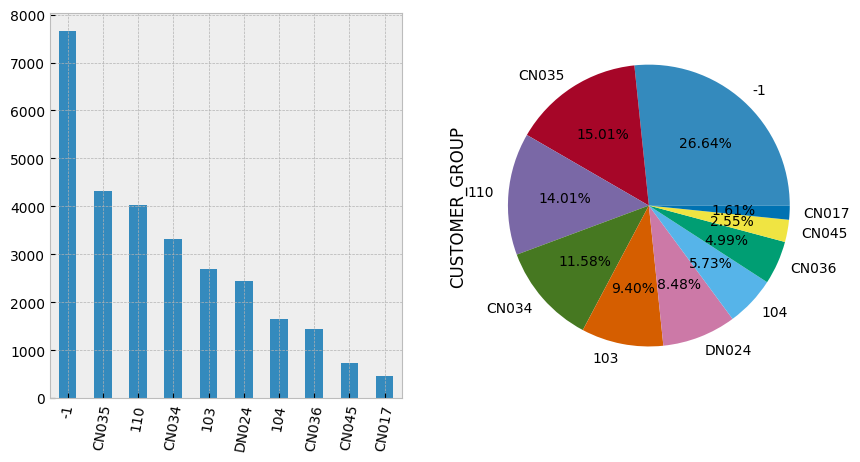

VNPAY        20330
IRIS-OTP      5944
VNPAY-OTP     3869
IRIS           680
Name: PROVIDER, dtype: int64

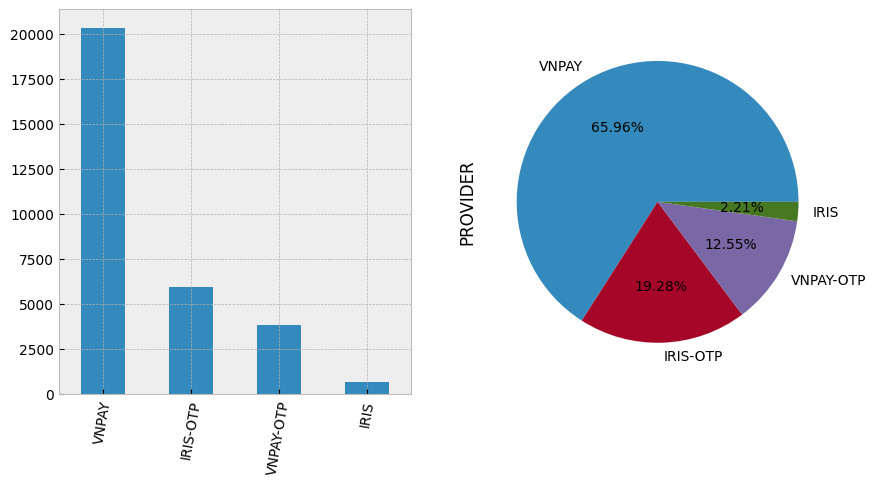

VTL    12655
MBF    12476
VNP     5200
VNM      343
Non       98
ITE       51
Name: TELCO, dtype: int64

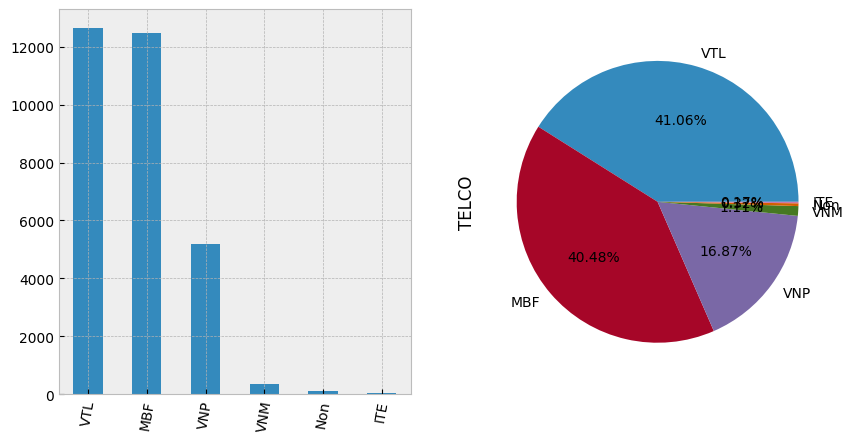

VTL    12720
MBF    12443
VNP     5168
VNM      343
Non       98
ITE       51
Name: TELCOMNP, dtype: int64

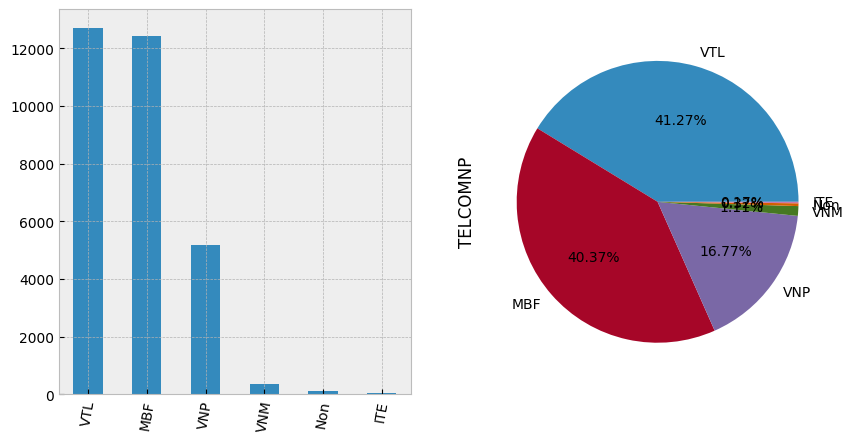

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,30823.000,110.000,110.000
count_pct_chg,100.000,-99.643,-99.643
mean,0.996,0.000,-inf
mean_pct_chg,100.000,-100.000,-inf
median,1.000,0.000,-inf
median_pct_chg,100.000,-100.000,-inf
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,1.000,0.000,-inf
max_pct_chg,100.000,-100.000,-inf


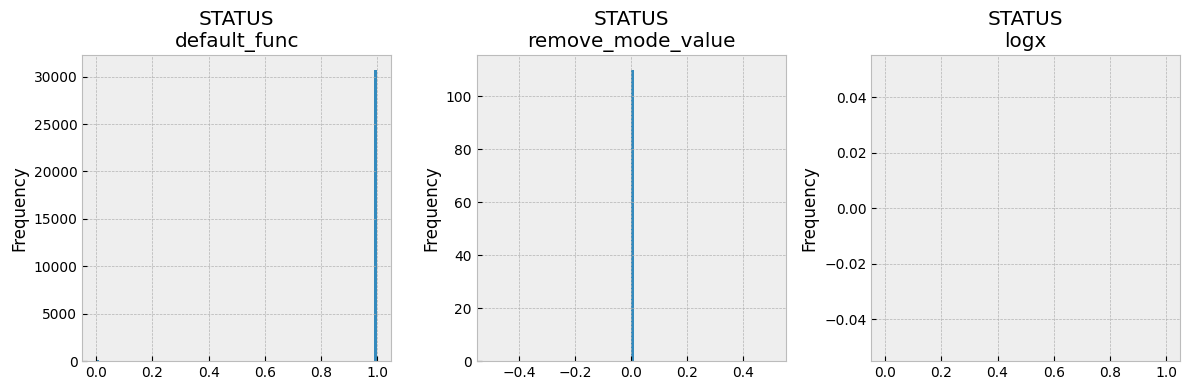

BIENDONGSODU          20780
OTP                    9813
SmsCredit                57
WL                       52
SendSMSJob               33
ImportSMS                23
UTTT                     17
Sacombank Checkout       16
CMSN                      7
NHACNOLD                  6
OfflineSmsCredit          5
CreditRenewal             4
TKPD                      4
SMSCardApprove            2
NHACLDEXPIRE              1
RESETPASSWORD             1
OTP_KHTT                  1
EKYC-Partner              1
Name: SERVICE, dtype: int64

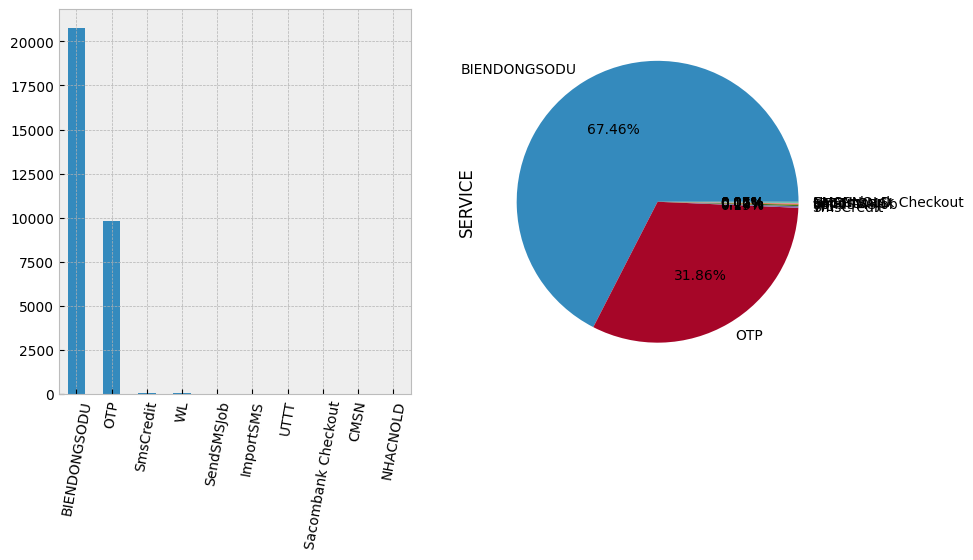

IIB               20798
MNS                  57
SCP                  52
ScheduleSystem       33
Portal               27
PROCESS_SMS          18
Epay                 17
KHTT                  1
Name: APPNAME, dtype: int64

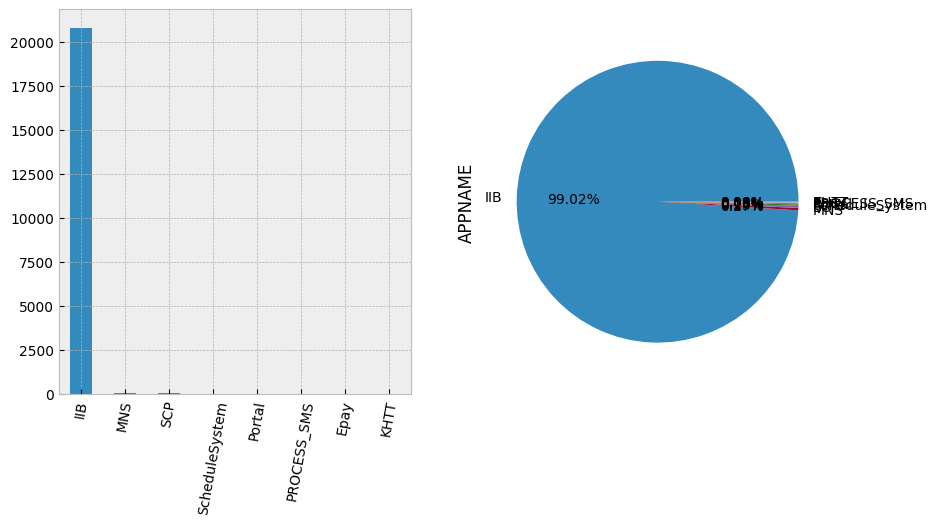

EBANKING    20817
OTP-NHDT     5904
OTP-TTT      3909
CARD          193
Name: FROM_1, dtype: int64

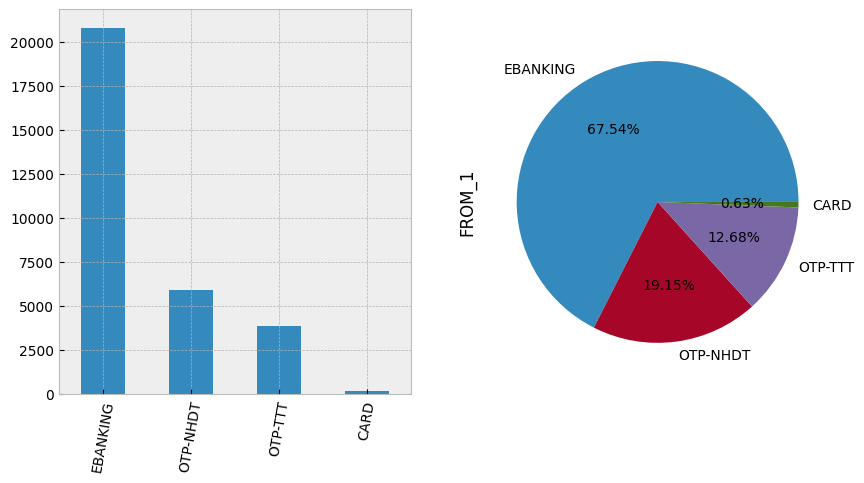

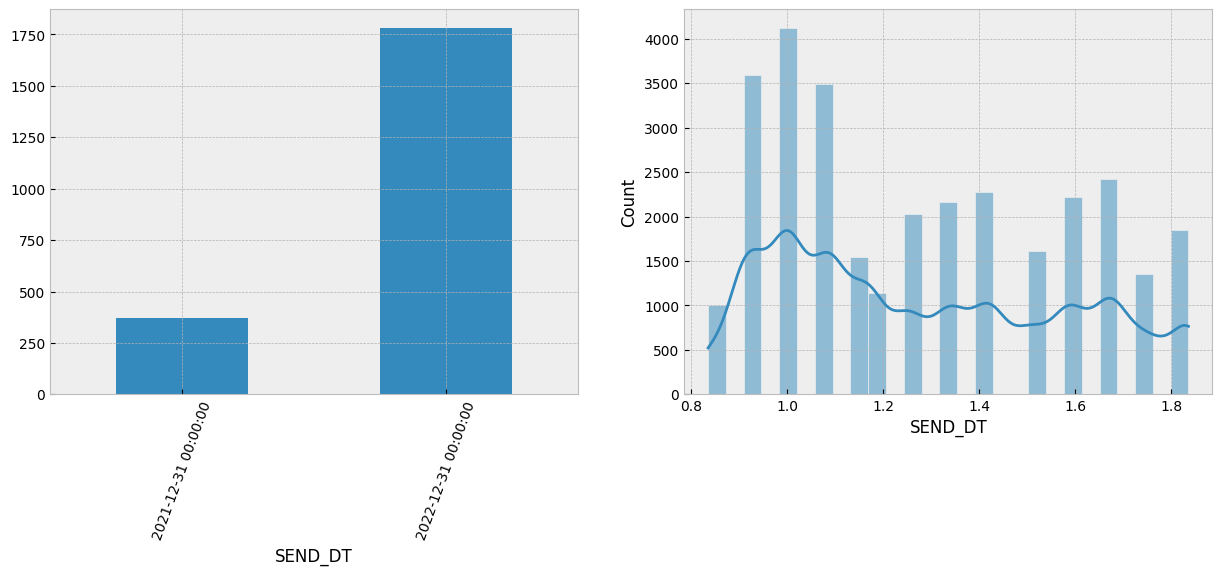

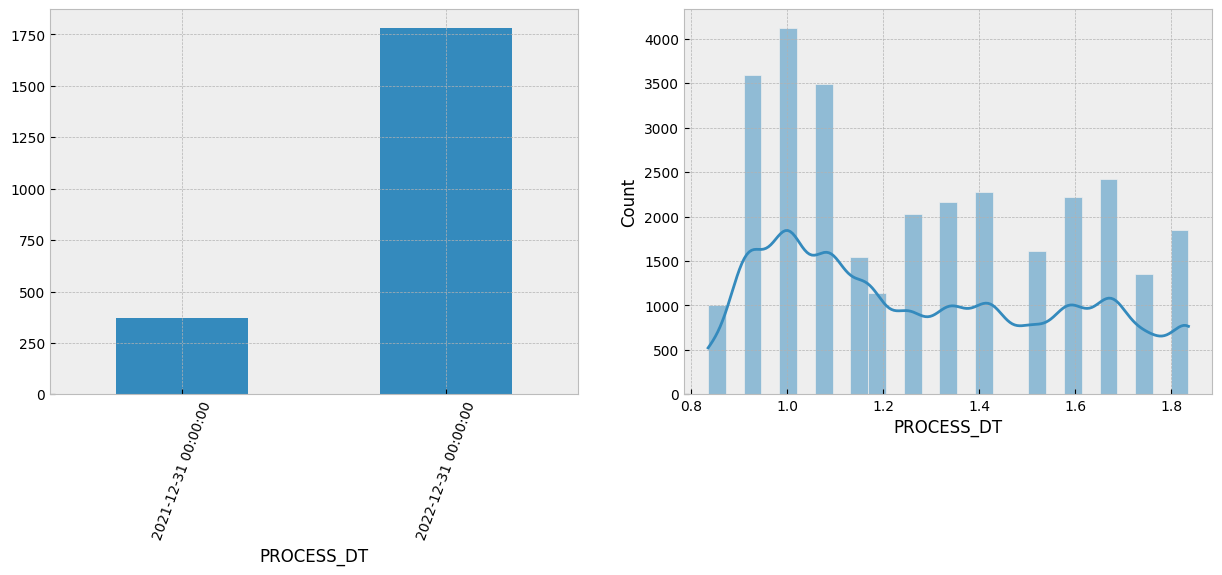

,default_func,remove_mode_value,logx
count,30823.000,63.000,63.000
count_pct_chg,100.000,-99.796,-99.796
mean,1.002,2.063,0.719
mean_pct_chg,100.000,105.902,-28.267
median,1.000,2.000,0.693
median_pct_chg,100.000,100.000,-30.685
min,1.000,2.000,0.693
min_pct_chg,100.000,100.000,-30.685
max,3.000,3.000,1.099
max_pct_chg,100.000,0.000,-63.380


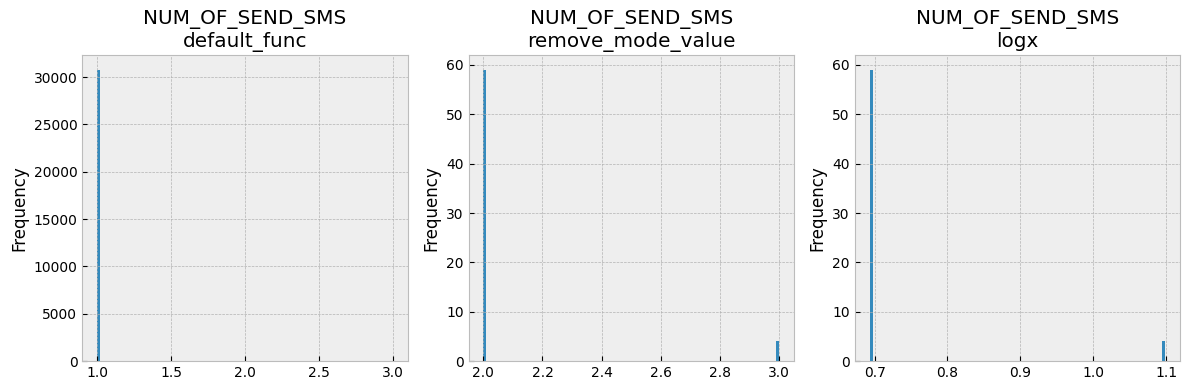

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,6513.000,3340.000,1942.000
count_pct_chg,100.000,-48.718,-70.183
mean,-1336104.446,-2605403.669,13.931
mean_pct_chg,100.000,95.000,-100.001
median,0.000,200000.000,13.710
median_pct_chg,100.000,inf,inf
min,-2930000000.000,-2930000000.000,0.000
min_pct_chg,100.000,-0.000,-100.000
max,1285000000.000,1285000000.000,20.974
max_pct_chg,100.000,0.000,-100.000


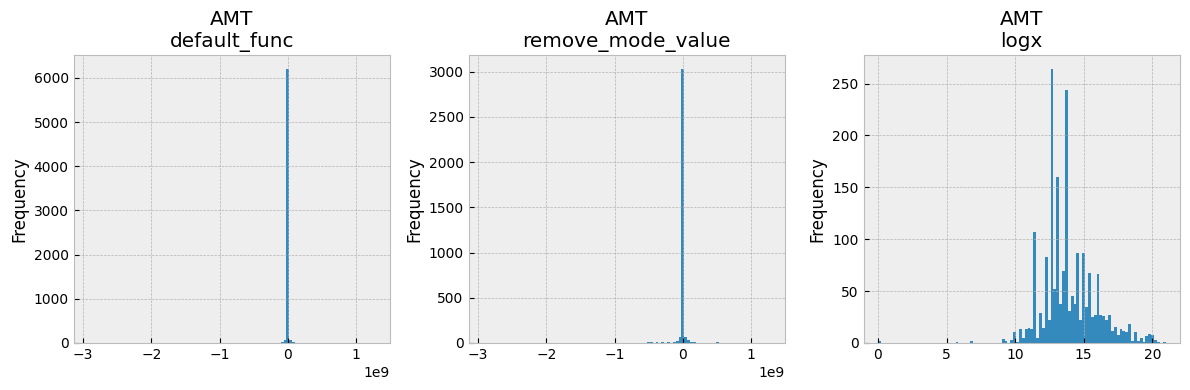

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['TXN_ID', 'COMPANY_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE',
        'CUSTOMER_KEY', 'CUSTOMER_CDE', 'SUB_SECTOR_CDE', 'SHORT_NAME',
        'CUSTOMER_GROUP', 'SMS_PHONE', 'ACCT_ID', 'PROVIDER', 'TELCO',
        'TELCOMNP', 'STATUS', 'SERVICE', 'APPNAME', 'FROM_1', 'TRACENO',
        'CONTENT_1', 'SEND_DT', 'CREATE_DT', 'PROCESS_DT', 'REC_CREATE_DT',
        'REC_UPDATE_DT', 'NUM_OF_SEND_SMS', 'AMT'],
       dtype='object'),
 27)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['SHORT_NAME', 'CUSTOMER_GROUP', 'PROVIDER', 'TELCO', 'TELCOMNP',
        'STATUS', 'SERVICE', 'APPNAME', 'FROM_1', 'SEND_DT', 'PROCESS_DT',
        'NUM_OF_SEND_SMS', 'AMT'],
       dtype='object', name='Column'),
 13)

In [27]:
df.columns

Index(['TXN_ID', 'COMPANY_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE',
       'CUSTOMER_KEY', 'CUSTOMER_CDE', 'SUB_SECTOR_CDE', 'SHORT_NAME',
       'CUSTOMER_GROUP', 'SMS_PHONE', 'ACCT_ID', 'PROVIDER', 'TELCO',
       'TELCOMNP', 'STATUS', 'SERVICE', 'APPNAME', 'FROM_1', 'TRACENO',
       'CONTENT_1', 'SEND_DT', 'CREATE_DT', 'PROCESS_DT', 'REC_CREATE_DT',
       'REC_UPDATE_DT', 'NUM_OF_SEND_SMS', 'AMT'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3